### Object Detection Finetuning

This notebook serves as an example of how to prepare and finetune Florance 2 for an object detection task. It is advisable to work your way through 01-Base_Model notebook first to understand the limitations and how Florance 2 works.

The goal is to finetune on a custom dataset, which we have previously labeled. Please find this in the sample_data folder. If you wish to use your own, change the json COCO file (ground truth) and the images provided. This notebook will be designed to start with just the contents in the raw data folder for this example. The contents in the other folders is generated as a result of this notebook.

We will be finetuning using Low-Rank Adaptation (LoRa). These are some high level notes on LoRa:
- LoRA Technique: Efficiently fine-tunes large pre-trained models for specific tasks using low-rank matrix approximations.
- Rank Decomposition: Injects trainable low-rank matrices into each layer, reducing the number of parameters to update.
- Frozen Weights: Keeps original model weights frozen, training only the low-rank matrices to reduce computational overhead and memory requirements.
- Performance: Often matches or exceeds full fine-tuning despite fewer trainable parameters.
- Low-Rank Matrices: Smaller, faster to process, and require fewer computational steps. They are added to the frozen model to generate new results.
- Training Process: Frozen matrices are multiplied by low-rank matrices to generate new matrices, which are trained to find optimal weights for desired results. This process is repeated for best performance.
- Further reading: `https://medium.com/nebius/fundamentals-of-lora-and-low-rank-fine-tuning-e748f2f1255d`, `https://arxiv.org/pdf/2106.09685`


#### Setup model and import libraries

In [7]:
# import libraries
import os
import json
import torch

import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    # AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from peft import LoraConfig, get_peft_model
from PIL import Image, ImageOps

from transformers import AutoProcessor, AutoModelForCausalLM 

# import custom libraries
from utils.image_functions import read_image, display_image
from utils.florence_functions import draw_bounding_boxes, inference_florance

# setup device and dtype if using GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"DEVICE: {device} \nTORCH DTYPE: {torch_dtype}")

# Load model and processor from Hugging Face
# microsoft/Florance-2-large-ft is the fine-tuned version of microsoft/Florance-2-large. It is finetuned for a variety of downstream tasks.
model_name = "microsoft/Florence-2-large-ft" # microsoft/Florance-2-large
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch_dtype, trust_remote_code=True).eval().to(device)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
florance2_setup = [model, processor, device, torch_dtype]

# setup correct file paths
data_path = "./sample_data/02-Object_Detection/"

DEVICE: cuda:0 
TORCH DTYPE: torch.float16


#### Base Model Performance

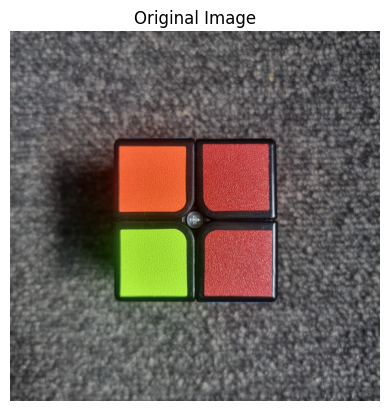

Prompts: ['<OD>']


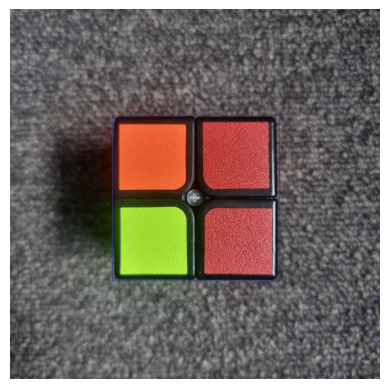

In [8]:
img_path = os.path.join(data_path, "raw", "20250424_155123.jpg")
img = read_image(img_path)
display_image(img, "Original Image")

task_input = "<OD>"
text_inputs = []
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)  # run object detection for no specific classes
combined_results = {"bboxes": [box for result in results for box in result[task_input]["bboxes"]], "labels": [label for result in results for label in result[task_input]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=5) # draw bounding boxes on image

#### Data Prep

Create a dataset by manually labeling your own images. This notebook expects COCO format, but if i you wish to use any alternative, then please modify the code as you see fit. You may use Azure Machine Learning labelling project or another labelling piece of software.

Some notes on formatting our ground truth:
- We pass a json object as ground truth with the following keys: image, prefix, suffix.
- There is a json object per image which is saved in a jsonl file.
- Each image must have a prefix and a suffix to finetune Florance 2. 
- The prefix is always the same for object detection: `<OD>`. The prefix is the task you want to perform.
- The suffix is the expected model response, each bounding box is described by a string with the following structure: 
    - `{class_name}<loc{x1}><loc{y1}><loc{x2}><loc{y2}>`. 
    - The values x1, y1, x2, y2 describe the bb. 
    - They should be normalised between 0 and 999 representing 0-0.999 position in the x and y co-ordinates.
    - the suffix should look like this: `product<loc_4><loc_57><loc_79><loc_109>product<loc_4><loc_109><loc_84><loc_143>...` wih every object in the class in the image

In [36]:
annotations_file = "2x2_rubix_COCO.json"

In [37]:
def convert_norm(i):
    """
    Converts normalised coordinates to florance normalised coordinates.
    [0-1] -> [0-999]
    """
    return int(i * 1000)

annotations_path = os.path.join(data_path, "raw", annotations_file)
with open(annotations_path, 'r') as f:
    annotation_data = json.load(f) 
    
# create dicts for image ID to file name and category ID to name
image_id_file_name = dict([[i["id"], i['file_name']] for i in annotation_data['images']])
image_id_categories = dict([i["id"], i['name']] for i in annotation_data['categories'])
annotations = annotation_data['annotations']

annotations_formatted = {} 
for annotation in annotations: # get image ID and then file name and category name
    image_file_name = image_id_file_name[annotation["image_id"]]
    image_category_name = image_id_categories[annotation["category_id"]]

    bbox = annotation["bbox"]
    x1, y1, w_b, h_b = bbox # coco is x, y, width, height so adjust to x1, y1, x2, y2
    bbox = [convert_norm(x1), convert_norm(y1), convert_norm(x1 + w_b), convert_norm(y1 + h_b)]
    
    bboxs = annotations_formatted.get(image_file_name, {}).get("bboxs", []) # get existing
    categories = annotations_formatted.get(image_file_name, {}).get("bboxs", [])
    
    categories.append(image_category_name)  
    bboxs.append(bbox)
    
    annotations_formatted[image_file_name] = {"categories":categories, "bboxs":bboxs} 
    
annotations_formatted

{'20250424_155133.jpg': {'categories': [[277, 331, 463, 518],
   'white',
   [511, 323, 694, 507],
   'yellow',
   [278, 554, 466, 744],
   'green',
   [512, 548, 698, 730]],
  'bboxs': [[277, 331, 463, 518],
   'white',
   [511, 323, 694, 507],
   'yellow',
   [278, 554, 466, 744],
   'green',
   [512, 548, 698, 730]]},
 '20250424_155154.jpg': {'categories': [[192, 247, 452, 496],
   'red',
   [200, 551, 459, 801],
   'orange',
   [512, 553, 770, 804],
   'blue',
   [519, 240, 777, 496]],
  'bboxs': [[192, 247, 452, 496],
   'red',
   [200, 551, 459, 801],
   'orange',
   [512, 553, 770, 804],
   'blue',
   [519, 240, 777, 496]]},
 '20250424_155123.jpg': {'categories': [[519, 303, 702, 495],
   'red',
   [525, 535, 712, 724],
   'yellow',
   [291, 528, 481, 721],
   'orange',
   [287, 307, 480, 490]],
  'bboxs': [[519, 303, 702, 495],
   'red',
   [525, 535, 712, 724],
   'yellow',
   [291, 528, 481, 721],
   'orange',
   [287, 307, 480, 490]]},
 '20250424_155139.jpg': {'categories': 

In [ ]:

        resize = True
        if resize:
            scale_factor = 0.25
            new_size = (int(new_image.width * scale_factor), int(new_image.height * scale_factor))
            new_image = new_image.resize(new_size, Image.ANTIALIAS)
            
        
def save_florance_format(annotations_formatted, processed_data_dir, training_jsonl_file, validation_jsonl_file, validation_split=0.7, multiplier=1000):
    annotations_json_strings = [] # save to jsonl format
    prefix = "<OD>" # OD finetuning task
    for image_file_name in annotations_formatted.keys():
            file_name_data = annotations_formatted[image_file_name]
            category_list = file_name_data["categories"]
            bbox_list = file_name_data["bboxs"]
            
            if len(category_list) != len(bbox_list):
                raise ValueError("Length of categories and bboxes do not match. Check data - there should be a 1-1 count.")
            
            suffix_lines = []
            for idx, bbox in enumerate(bbox_list):
                class_name = category_list[idx]
                x1, y1, x2, y2 = [int(i) for i in (np.array(bbox) * multiplier)] # adjust multiplier for florance model (1000)
                suffix_line = f"{class_name}<loc_{x1}><loc_{y1}><loc_{x2}><loc_{y2}>"
                suffix_lines.append(suffix_line)
            json_obj = {
                "image": image_file_name,
                "prefix": prefix,
                "suffix": "".join(suffix_lines)
            }
            json_string = json.dumps(json_obj, separators=(',', ':'))
            annotations_json_strings.append(json_string)

    train_output_json_path = os.path.join(processed_data_dir, training_jsonl_file)
    val_output_json_path = os.path.join(processed_data_dir, validation_jsonl_file)

    shuffle = True
    if shuffle: # random
        validation_idx = int(len(annotations_json_strings) * validation_split)
        np.random.shuffle(annotations_json_strings)
        train = annotations_json_strings[:validation_idx]
        val = annotations_json_strings[validation_idx:]
    else: # select for dev
        train = [annotations_json_strings[0], annotations_json_strings[2]]
        val = [annotations_json_strings[1]]

    with open(train_output_json_path, 'w') as json_file:
        json_file.write("\n".join(train))
    print(f"{len(train)} train annotations have been written to {train_output_json_path}")

    with open(val_output_json_path, 'w') as json_file:
        json_file.write("\n".join(val))
    print(f"{len(val)} validation annotations have been written to {val_output_json_path}")

In [5]:
data_dir = "./data/raw" 
processed_data_dir = "./data/processed"
annotations_file = "annotations_coco.json"
multiplier = 1000 # multiply bbox values by this number - for florance model
normalise_bbox = False # normalise if absolute values in coco
validation_split = 1
training_jsonl_file = "train_annotations.jsonl"
validation_jsonl_file = "val_annotations.jsonl"

annotations_formatted = preprocess_annotations_data(data_dir, annotations_file, normalise_bbox)
annotations_formatted = crop_images_save_adjust_bbox(annotations_formatted, data_dir, processed_data_dir)
save_florance_format(annotations_formatted, processed_data_dir, training_jsonl_file, validation_jsonl_file, validation_split)

C:\Users\henrytaylor\AppData\Local\Temp\ipykernel_12160\2866673256.py:186: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_image = new_image.resize(new_size, Image.ANTIALIAS)


12 train annotations have been written to ./data/processed\train_annotations.jsonl
0 validation annotations have been written to ./data/processed\val_annotations.jsonl


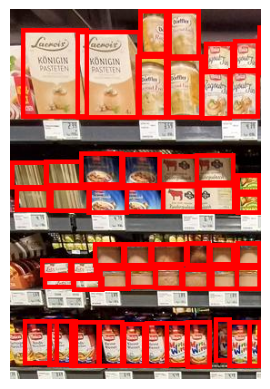

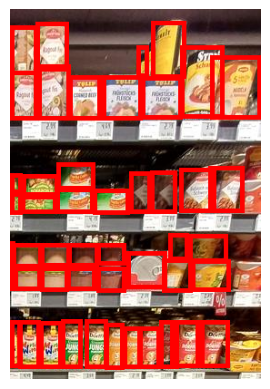

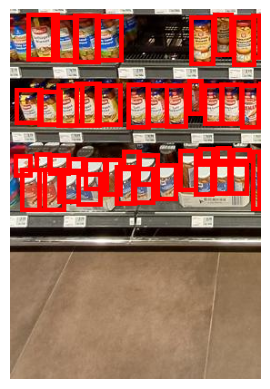

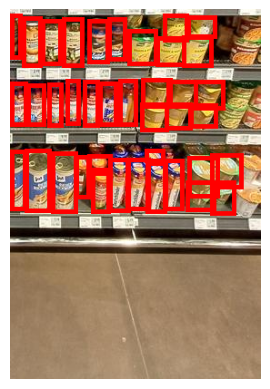

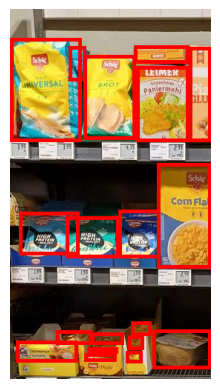

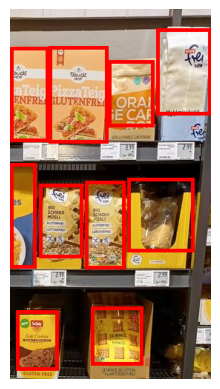

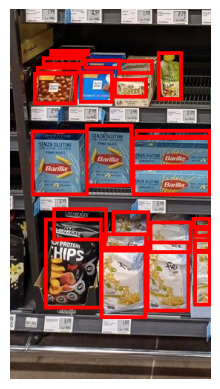

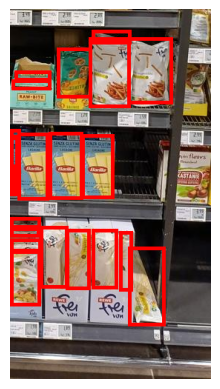

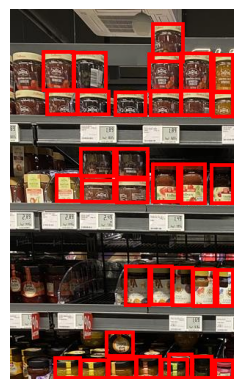

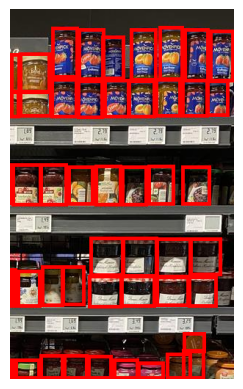

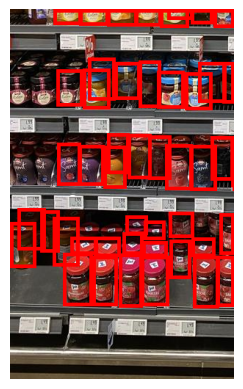

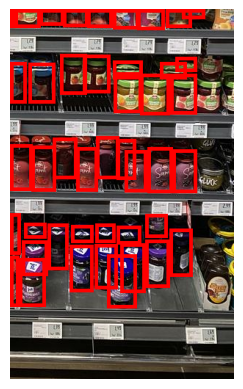

In [6]:
# check images and bounding boxes on processed images

for image_file_name in annotations_formatted.keys():
    img_path = os.path.join(processed_data_dir, image_file_name)
    image = Image.open(img_path)
    image = ImageOps.exif_transpose(image)
    width, height = image.width, image.height
    combined_results = {"bboxes": np.array(annotations_formatted[image_file_name]["bboxs"]) * [width, height, width, height], "labels": annotations_formatted[image_file_name]["categories"]}
    draw_bounding_boxes(image, combined_results, size_bb=5, size_text=10, label_bb=False, color_bb=False)

#### Finetuning the model using custom dataset

In [7]:
# DATA SET TORCH
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")

class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

# Initiate DetectionsDataset and DataLoader for train and validation subsets
BATCH_SIZE = 4
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = os.path.join(processed_data_dir, training_jsonl_file),
    image_directory_path = processed_data_dir
)

val_dataset = DetectionDataset(
    jsonl_file_path = os.path.join(processed_data_dir, validation_jsonl_file),
    image_directory_path = processed_data_dir
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [8]:
# training loop

def train_model(train_loader, val_loader, model, processor, classes, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=2,
        num_training_steps=num_training_steps,
    )

    best_products_identified = -10
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs = inputs.to(DEVICE, dtype=torch_dtype)
            
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)
            
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            
            loss.backward(); optimizer.step(); lr_scheduler.step(); optimizer.zero_grad()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")
        
        perform_validation = False
        if perform_validation:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                    inputs = inputs.to(DEVICE, dtype=torch_dtype)

                    input_ids = inputs["input_ids"]
                    pixel_values = inputs["pixel_values"]
                    labels = processor.tokenizer(
                        text=answers,
                        return_tensors="pt",
                        padding=True,
                        return_token_type_ids=False
                    ).input_ids.to(DEVICE)

                    outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                    loss = outputs.loss
                    val_loss += loss.item()

                avg_val_loss = val_loss / len(val_loader)
                print(f"Average Validation Loss: {avg_val_loss}")

            save_on_logic = False # true if save on custom logic
            if save_on_logic:
                bb_labels = inference_florance(classes, val_dataset[0][2], model, processor) # check base model
                if (epoch+1)%2==0: # check inference every 2 epochs
                    output_dir = f"./model_checkpoints/best_inference_products_ID"
                    inference_count = dict(Counter(bb_labels["labels"]))
                    inference_count = {k: inference_count[k] for k in classes if k in inference_count} 
                    try:
                        counted_products = inference_count['product'] # count number of products idetified at inference
                    except:
                        counted_products = 0
                    if counted_products>best_products_identified:
                        os.makedirs(output_dir, exist_ok=True)
                        model.save_pretrained(output_dir, save_embedding_layers=True)
                        processor.save_pretrained(output_dir, save_embedding_layers=True)
                        with open(os.path.join(output_dir, 'checkpoint_info.txt'), 'w') as file: file.write(f'Epoch: {epoch+1}, Products Identified: {counted_products}')
                        print(f"Model saved at {output_dir}")
                        best_products_identified = counted_products
        
        save_x = 2 # save every x epochs
        if (epoch+1)%save_x==0: # save every x epochs
            output_dir = f"./model_checkpoints/epoch_{epoch+1}"
            os.makedirs(output_dir, exist_ok=True)
            model.save_pretrained(output_dir, save_embedding_layers=True)
            processor.save_pretrained(output_dir, save_embedding_layers=True)
            print(f"Model saved at {output_dir}")
        
        print("\n")

In [ ]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"DEVICE: {DEVICE} \nTORCH DTYPE: {torch_dtype}")

model_name = "microsoft/Florence-2-base-ft" # "microsoft/Florence-2-base" "microsoft/Florence-2-large" "microsoft/Florence-2-large-ft" 
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch_dtype, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

# lora_alpha
    # Purpose: lora_alpha is a scaling factor for the low-rank adaptation matrices. It controls the magnitude of the adaptation applied to the pre-trained model's weights.
    # Effect of Changing lora_alpha:
    # Increasing lora_alpha: This amplifies the impact of the low-rank adaptation, potentially leading to more significant changes in the model's behavior. It can help the model adapt better to new tasks but might also increase the risk of overfitting.
    # Decreasing lora_alpha: This reduces the impact of the low-rank adaptation, making the changes more subtle. It can help in preventing overfitting but might limit the model's ability to adapt to new tasks.
# r
    # Purpose: r is the rank of the low-rank adaptation matrices. It determines the number of parameters added to the model for adaptation.
    # Effect of Changing r:
    # Increasing r: This adds more parameters to the model, allowing for more complex adaptations. It can improve the model's performance on new tasks but also increases computational and memory requirements.
    # Decreasing r: This reduces the number of parameters, making the adaptation simpler and more efficient. It can help in reducing computational costs but might limit the model's ability to capture complex patterns in the data.

config = LoraConfig(
    lora_alpha=30, # 8 # This amplifies the impact of the low-rank adaptation
    r=55, # 8 # It determines the number of parameters added to the model for adaptation.   
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.15, #0.05,
    bias="none", # none, all, lora_only
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

classes = ["product"]
if len(val_dataset)>0:
    _ = inference_florance(classes, val_dataset[0][2], model, processor) # check base model
    
# change batch size, lora_alpha, r, lr to improve performance - this is what ive found to work well
# lora_dropout also seems to impove overfitting.
# there is evidence of products being identified in the inference, but in inference it isnt IDing all of them, only 1/3. May need to change parameters and also include more data.
# can also test microsoft/Florence-2-large or microsoft/Florence-2-base

# set up lora model
peft_model = get_peft_model(model, config); peft_model.print_trainable_parameters(); print("\n---\n")

DEVICE: cuda:0 
TORCH DTYPE: torch.float16


Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


trainable params: 13,268,255 || all params: 284,072,223 || trainable%: 4.6707

---



In [ ]:
EPOCHS = 12 # 15
LR = 1e-3
torch.cuda.empty_cache()
train_model(train_loader, val_loader, peft_model, processor, classes, epochs=EPOCHS, lr=LR)

Training Epoch 1/12: 100%|██████████| 3/3 [02:40<00:00, 53.60s/it]


Average Training Loss: 8.171875




Training Epoch 2/12: 100%|██████████| 3/3 [03:08<00:00, 62.77s/it]


Average Training Loss: 4.854166666666667
Model saved at ./model_checkpoints/epoch_2




Training Epoch 3/12: 100%|██████████| 3/3 [02:43<00:00, 54.47s/it]


Average Training Loss: 2.4244791666666665




Training Epoch 4/12: 100%|██████████| 3/3 [03:06<00:00, 62.14s/it]


Average Training Loss: 1.9908854166666667
Model saved at ./model_checkpoints/epoch_4




Training Epoch 5/12: 100%|██████████| 3/3 [02:44<00:00, 54.91s/it]


Average Training Loss: 1.6100260416666667




Training Epoch 6/12: 100%|██████████| 3/3 [03:06<00:00, 62.18s/it]


Average Training Loss: 1.5188802083333333
Model saved at ./model_checkpoints/epoch_6




Training Epoch 7/12:   0%|          | 0/3 [00:00<?, ?it/s]

##### Inference

In [ ]:
import os
import torch
from transformers import (
    # AdamW,
    AutoModelForCausalLM,
    AutoProcessor
)
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"DEVICE: {DEVICE} \nTORCH DTYPE: {torch_dtype}")

processed_data_dir = "./data/processed"

# Load the model and processor from the saved weights
model_file_name = "epoch_4" # "epoch_12" # "best_inference_products_ID"

output_dir = f"./model_checkpoints/{model_file_name}"
model = AutoModelForCausalLM.from_pretrained(output_dir, torch_dtype=torch_dtype, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(output_dir, trust_remote_code=True)

DEVICE: cuda:0 
TORCH DTYPE: torch.float16


Successfully detected the following objects: {'product': 4}


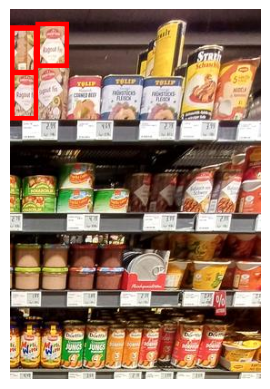

In [ ]:
test_image = "1_shelf_image_2.jpg"

# Perform inference
classes = ["product"]
image_path = os.path.join(processed_data_dir, test_image)
image = Image.open(image_path)
image = ImageOps.exif_transpose(image)
combined_results = inference_florance(classes, image, model, processor)
draw_bounding_boxes(image, combined_results, size_bb=5, size_text=10, label_bb=False, color_bb=False)